In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.preprocessing import MinMaxScaler



from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [ ]:
train_values = pd.read_csv("/content/drive/My Drive/earthQuake/train_values.csv")
test_values = pd.read_csv("/content/drive/My Drive/earthQuake/test_values.csv")
train_labels = pd.read_csv("/content/drive/My Drive/earthQuake/train_labels.csv")

IDtest = test_values["building_id"]

In [ ]:
all_train=pd.concat([train_values,train_labels], axis=1)

In [ ]:
all_train.sample(3)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,building_id,damage_grade
169343,958407,27,1394,7631,2,5,7,7,t,u,x,f,s,s,d,0,0,0,0,0,1,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0,958407,1
153045,427814,22,1152,553,2,0,17,5,t,r,n,f,x,s,d,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,427814,2
62264,772194,20,158,621,1,5,11,3,t,i,n,v,j,s,u,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,772194,1


In [ ]:
all_train.drop('building_id', axis=1,inplace=True)

In [ ]:
all_train.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

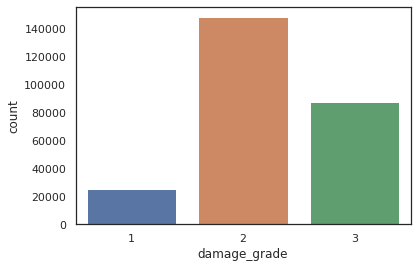

In [ ]:
sns.countplot(all_train.damage_grade)

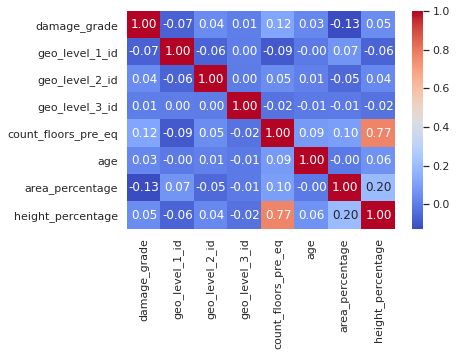

In [ ]:
g = sns.heatmap(all_train[["damage_grade","geo_level_1_id","geo_level_2_id","geo_level_3_id","count_floors_pre_eq","age","area_percentage","height_percentage"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")


In [ ]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
geo_level_1_id                            260601 non-null int64
geo_level_2_id                            260601 non-null int64
geo_level_3_id                            260601 non-null int64
count_floors_pre_eq                       260601 non-null int64
age                                       260601 non-null int64
area_percentage                           260601 non-null int64
height_percentage                         260601 non-null int64
land_surface_condition                    260601 non-null object
foundation_type                           260601 non-null object
roof_type                                 260601 non-null object
ground_floor_type                         260601 non-null object
other_floor_type                          260601 non-null object
position                                  260601 non-null object
plan_configuration                        260601 no

In [ ]:
all_train.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000,260601.000
mean,13.900,701.075,6257.876,2.130,26.535,8.018,5.434,0.089,0.762,0.034,0.018,0.068,0.075,0.255,0.085,0.043,0.016,0.015,0.984,0.112,0.064,0.034,0.008,0.001,0.000,0.001,0.000,0.000,0.000,0.005,2.238
std,8.034,412.711,3646.370,0.728,73.566,4.392,1.918,0.284,0.426,0.182,0.134,0.252,0.264,0.436,0.279,0.202,0.125,0.121,0.418,0.315,0.245,0.180,0.090,0.031,0.019,0.033,0.014,0.012,0.009,0.071,0.612
min,0.000,0.000,0.000,1.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,7.000,350.000,3073.000,2.000,10.000,5.000,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,12.000,702.000,6270.000,2.000,15.000,7.000,5.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
75%,21.000,1050.000,9412.000,2.000,30.000,9.000,6.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
max,30.000,1427.000,12567.000,9.000,995.000,100.000,32.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,9.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,3.000


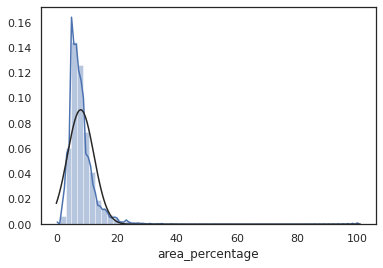

In [ ]:
sns.distplot(all_train.area_percentage, fit=norm)

In [ ]:
all_train = pd.get_dummies(all_train)


In [ ]:
all_train.shape

(260601, 69)

In [ ]:
print('One', round(all_train['damage_grade'].value_counts()[1]/len(all_train) * 100,2), '% of the dataset')
print('Two', round(all_train['damage_grade'].value_counts()[2]/len(all_train) * 100,2), '% of the dataset')
print('Three', round(all_train['damage_grade'].value_counts()[3]/len(all_train) * 100,2), '% of the dataset')


One 9.64 % of the dataset
Two 56.89 % of the dataset
Three 33.47 % of the dataset


In [ ]:
all_train.damage_grade.value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [ ]:
y=all_train['damage_grade']
X=all_train.drop('damage_grade', axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.50, random_state=42)



In [ ]:
original_Xtrain.shape

(130300, 68)

In [ ]:
original_ytrain.shape

(130300,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=4, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(original_Xtrain,original_ytrain)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 89.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 104.2min finished


0.7162240982348427

In [ ]:
sample_pred_1 = gsRFC.best_estimator_.predict(original_Xtest)
print('##### Classification Report of Random Forest Classfier #####')
print()
print(classification_report(original_ytest,sample_pred_1))
print('##### Confusion Matrix of Random Forest Classfier #####')
print()
print(confusion_matrix(original_ytest,sample_pred_1))


##### Classification Report of Random Forest Classfier #####

              precision    recall  f1-score   support

           1       0.70      0.42      0.52     12658
           2       0.71      0.86      0.78     74104
           3       0.75      0.57      0.64     43539

    accuracy                           0.72    130301
   macro avg       0.72      0.62      0.65    130301
weighted avg       0.72      0.72      0.71    130301

##### Confusion Matrix of Random Forest Classfier #####

[[ 5328  7188   142]
 [ 2143 63799  8162]
 [  174 18738 24627]]


In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=4, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(original_Xtrain,original_ytrain)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 193.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 289.0min finished


0.7292018419033001

In [ ]:
sample_pred_2 = GBC_best.predict(original_Xtest)
print('##### Classification Report of Random Forest Classfier #####')
print()
print(classification_report(original_ytest,sample_pred_2))
print('##### Confusion Matrix of Random Forest Classfier #####')
print()
print(confusion_matrix(original_ytest,sample_pred_2))


##### Classification Report of Random Forest Classfier #####

              precision    recall  f1-score   support

           1       0.70      0.47      0.56     12658
           2       0.73      0.85      0.78     74104
           3       0.75      0.61      0.67     43539

    accuracy                           0.73    130301
   macro avg       0.73      0.64      0.67    130301
weighted avg       0.73      0.73      0.72    130301

##### Confusion Matrix of Random Forest Classfier #####

[[ 5952  6564   142]
 [ 2393 62993  8718]
 [  188 16904 26447]]


In [ ]:
#Final fit and pred
GBC_best.fit(X,y)
final_pred=GBC_best.predict(test_values)

In [ ]:
sub = pd.DataFrame()
sub['damage_grade'] = (final_pred)
sub.to_csv('submission2.csv',index=False)

In [ ]:
test_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_values.drop('building_id', axis=1, inplace=True)

In [ ]:
test_values=pd.get_dummies(test_values)

In [ ]:
test_values.shape

(86868, 68)